In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from arch import arch_model


In [2]:
# Connect to WRDS
db = wrds.Connection(wrds_username='simengut')

Loading library list...
Done


In [4]:
# read returns_pivot from csv file in data folder
returns_pivot = pd.read_csv('data/returns_pivot.csv')

# make date teh index
returns_pivot.set_index('date', inplace=True)
returns_pivot

tickers = returns_pivot.columns.tolist()


## Portfolio Construction

### (A) Equal-weighted Portfolio


In [5]:
equal_weights = np.repeat(1/len(tickers), len(tickers))
returns_pivot['Equal_Weighted'] = returns_pivot.dot(equal_weights)

### (B) Markowitz Mean-Variance Portfolio:


In [6]:
def markowitz_opt(returns, risk_aversion=1.0):
    # Convert pandas Series and DataFrame to numpy arrays
    mu = returns.mean().values
    Sigma = returns.cov().values
    
    # Create optimization variables
    n = len(mu)
    w = cp.Variable(n)
    
    # Define objective function (mean-variance optimization)
    objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))
    
    # Define constraints
    constraints = [
        cp.sum(w) == 1,  # weights sum to 1
        w >= 0  # no short selling
    ]
    
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return w.value

In [7]:
markowitz_weights = markowitz_opt(returns_pivot[tickers])
returns_pivot['Markowitz'] = returns_pivot[tickers].dot(markowitz_weights)


### (C) Risk Parity Portfolio:

In [8]:
import numpy as np

def risk_parity_weights_iterative(Sigma, max_iter=500, tol=1e-8):
    """
    Solve for risk-parity weights via an iterative approach.
    Sigma: covariance matrix (numpy array, n x n)
    Returns: weight vector w (n x 1)
    """
    n = Sigma.shape[0]
    w = np.ones(n) / n  # start with equal weights
    for _ in range(max_iter):
        w_old = w.copy()
        
        # portfolio risk = w^T Sigma w
        portfolio_risk = w @ Sigma @ w  
        
        # marginal risk = (Sigma w), shape (n,)
        marginal_risk = Sigma @ w  
        
        # each asset's risk contribution = w_i * (Sigma w)_i
        risk_contrib = w * marginal_risk
        
        # target: each risk_contrib ~ portfolio_risk / n
        # The iterative update can be done as:
        w = w * (portfolio_risk / risk_contrib)  # the 'Euler' or 'Newton' style step
        w = w / w.sum()  # normalize to sum to 1

        # check convergence
        if np.linalg.norm(w - w_old) < tol:
            break

    return w

In [9]:
Sigma = returns_pivot[tickers].cov().values
rp_weights = risk_parity_weights_iterative(Sigma)
print("Risk Parity Weights:", rp_weights)
returns_pivot['Risk_Parity'] = returns_pivot[tickers].dot(rp_weights)

Risk Parity Weights: [0.16518235 0.13664151 0.14864162 0.19815209 0.17318288 0.17819955]


In [13]:
# write returns_pivot to csv file in data folder
returns_pivot.to_csv('data/returns_pivot_with_portfolios.csv')


In [40]:
# Convert portfolio columns to numeric
returns_pivot['Equal_Weighted'] = pd.to_numeric(returns_pivot['Equal_Weighted'], errors='coerce')
returns_pivot['Markowitz'] = pd.to_numeric(returns_pivot['Markowitz'], errors='coerce')
returns_pivot['Risk_Parity'] = pd.to_numeric(returns_pivot['Risk_Parity'], errors='coerce')

In [41]:
returns_pivot

,ICLN,PBW,QCLN,IXC,VDE,XLE,Equal_Weighted,Markowitz,Risk_Parity
date,,,,,,,,,
2008-07-31,-0.026070,-0.026087,-0.051933,-0.137549,-0.144426,-0.159132,-0.090866,-0.117912,-0.096215
2008-08-29,0.024518,0.039391,0.066980,-0.009118,-0.006781,0.003360,0.019725,0.027823,0.017006
2008-09-30,-0.272376,-0.249116,-0.242303,-0.132505,-0.151297,-0.149162,-0.199460,-0.184977,-0.194086
2008-10-31,-0.397254,-0.335128,-0.335092,-0.178202,-0.200472,-0.187994,-0.272357,-0.244557,-0.264750
2008-11-28,-0.128240,-0.140688,-0.173135,-0.017748,-0.028173,-0.021790,-0.084962,-0.079986,-0.078421
...,...,...,...,...,...,...,...,...,...
2024-08-30,0.009894,-0.102505,-0.036865,-0.004509,-0.024795,-0.020706,-0.029914,-0.026920,-0.026729
2024-09-30,0.027992,0.038776,0.020360,-0.035042,-0.030666,-0.030155,-0.001456,-0.010731,-0.004680
2024-10-31,-0.108237,0.000998,-0.076859,-0.000741,0.009553,0.008998,-0.027715,-0.024016,-0.026056


### Step 3: Historical Stress-Testing

Evaluate returns during specified crises.

Means:
                     ICLN       PBW      QCLN       IXC       VDE       XLE  \
2008 Crisis    -0.163300 -0.161166 -0.143335 -0.083134 -0.095836 -0.090871   
COVID Crash    -0.025548 -0.015442 -0.005996 -0.090711 -0.063712 -0.063606   
2022 Inflation  0.005530 -0.026126 -0.006709  0.044845  0.055548  0.055911   

                Equal_Weighted  Markowitz  Risk_Parity  
2008 Crisis          -0.122940  -0.111045    -0.119565  
COVID Crash          -0.044169  -0.041454    -0.047564  
2022 Inflation        0.021500   0.031832     0.024816  
STDs:
                     ICLN       PBW      QCLN       IXC       VDE       XLE  \
2008 Crisis     0.182862  0.122438  0.149197  0.063297  0.073448  0.072228   
COVID Crash     0.190847  0.243871  0.226814  0.235815  0.350876  0.335634   
2022 Inflation  0.103855  0.139818  0.114929  0.104826  0.119960  0.122929   

                Equal_Weighted  Markowitz  Risk_Parity  
2008 Crisis           0.105748   0.095778     0.102336  
COVID Crash      

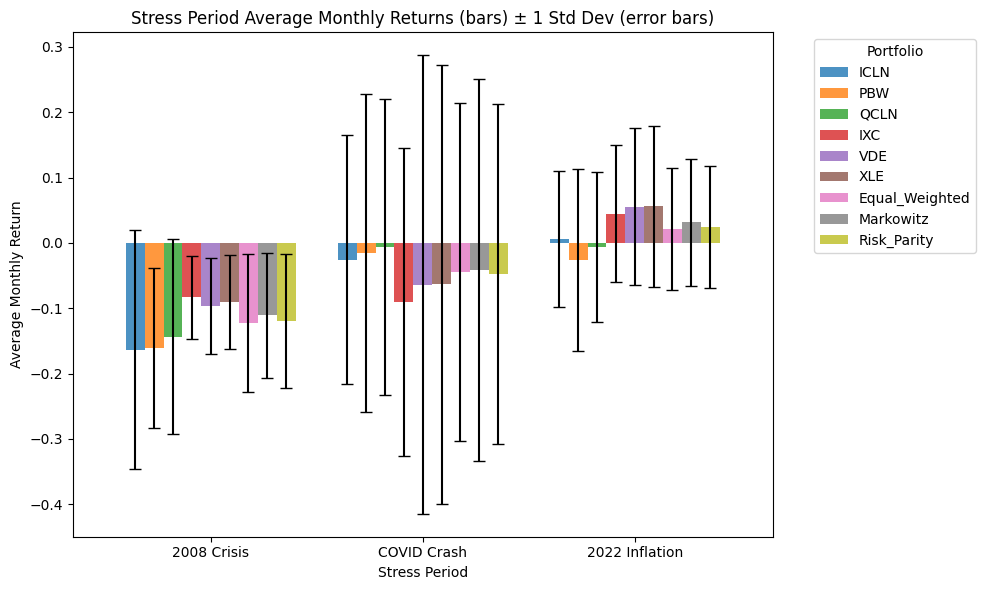

In [42]:
stress_periods = {
    '2008 Crisis': ('2008-09-01', '2009-03-01'),
    'COVID Crash': ('2020-02-01', '2020-05-01'),
    '2022 Inflation': ('2022-01-01', '2022-12-01')
}

stress_means = {}
stress_stds = {}

for period_name, (start, end) in stress_periods.items():
    # Subset the data to the stress period
    subset = returns_pivot.loc[start:end]
    # Compute mean (average monthly returns)
    stress_means[period_name] = subset.mean()
    # Compute standard deviation
    stress_stds[period_name] = subset.std()

# Convert these dicts to DataFrames, with crises as rows and portfolios as columns
df_means = pd.DataFrame(stress_means).T  # shape: (#crises x #portfolios)
df_stds = pd.DataFrame(stress_stds).T    # same shape


print("Means:\n", df_means)
print("STDs:\n", df_stds)

plt.figure(figsize=(10, 6))

# We use df_means.plot with 'bar' and specify yerr=df_stds
# This will add error bars of +/- the standard deviation
ax = df_means.plot(
    kind='bar',
    yerr=df_stds,
    ax=plt.gca(),     # plot on current axes
    capsize=4,        # length of error bar caps
    alpha=0.8,        # transparency
    width=0.8,        # bar width
)

# Add title and axis labels
plt.title("Stress Period Average Monthly Returns (bars) ± 1 Std Dev (error bars)")
plt.ylabel("Average Monthly Return")
plt.xlabel("Stress Period")

# Rotate x-labels if needed
plt.xticks(rotation=0)

# Place legend outside or keep it inside
plt.legend(title="Portfolio", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Step 4: Monte Carlo Simulation & GARCH Modeling

Perform simulations to model future portfolio performance.


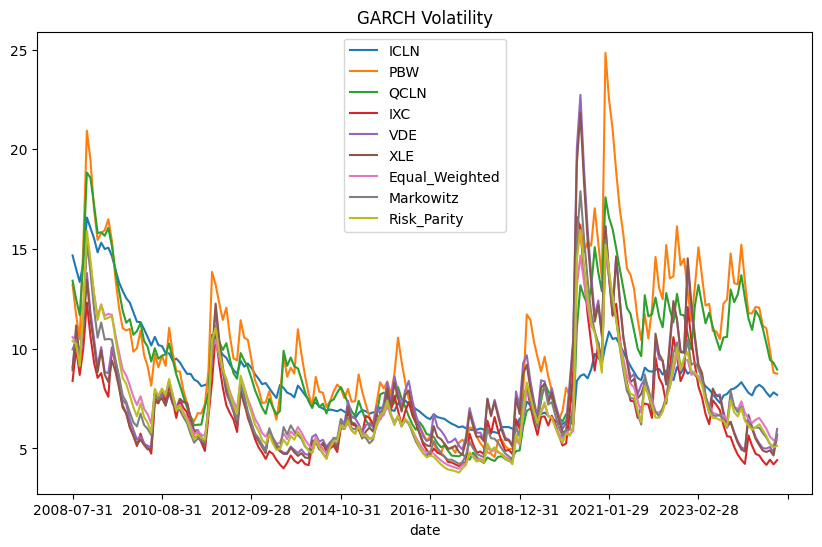

Descriptive Stats of Conditional Volatilities:
             ICLN         PBW        QCLN         IXC         VDE         XLE  \
count  198.000000  198.000000  198.000000  198.000000  198.000000  198.000000   
mean     8.481735   10.116853    9.232342    6.812125    7.670876    7.507565   
std      2.265447    3.796870    3.260617    2.307015    2.833246    2.820702   
min      5.762538    4.564104    4.271271    4.007843    4.679784    4.511652   
25%      6.871910    7.283667    6.734001    5.083665    5.628526    5.448978   
50%      8.051870    9.484314    8.987555    6.437469    7.070665    6.837425   
75%      9.122324   12.291836   11.620642    7.759607    8.605574    8.317697   
max     16.580377   24.842784   18.835220   16.607212   22.732344   21.844114   

       Equal_Weighted   Markowitz  Risk_Parity  
count      198.000000  198.000000   198.000000  
mean         7.202563    7.173644     7.117449  
std          2.350804    2.441665     2.488761  
min          3.980341    4.

In [43]:
tickers_and_port = tickers + ['Equal_Weighted', 'Markowitz', 'Risk_Parity']

# Monte Carlo Simulation
def monte_carlo_sim(returns, simulations=1000, days=252):
    mean_ret = returns.mean().values
    cov_ret = returns.cov().values
    paths = np.zeros((days, simulations))
    for i in range(simulations):
        random_path = np.random.multivariate_normal(mean_ret, cov_ret, days)
        paths[:, i] = np.cumprod(1 + random_path.mean(axis=1)) - 1
    return paths

mc_paths = monte_carlo_sim(returns_pivot[tickers_and_port])

# GARCH Model Example (for volatility)
garch_volatility = {}
for ticker in tickers_and_port:
    garch = arch_model(returns_pivot[ticker] * 100, vol='Garch', p=1, q=1)
    res = garch.fit(disp='off')
    garch_volatility[ticker] = res.conditional_volatility

vol_df = pd.DataFrame(garch_volatility)
vol_df.plot(figsize=(10, 6), title='GARCH Volatility')
plt.show()

print("Descriptive Stats of Conditional Volatilities:")
print(vol_df.describe())


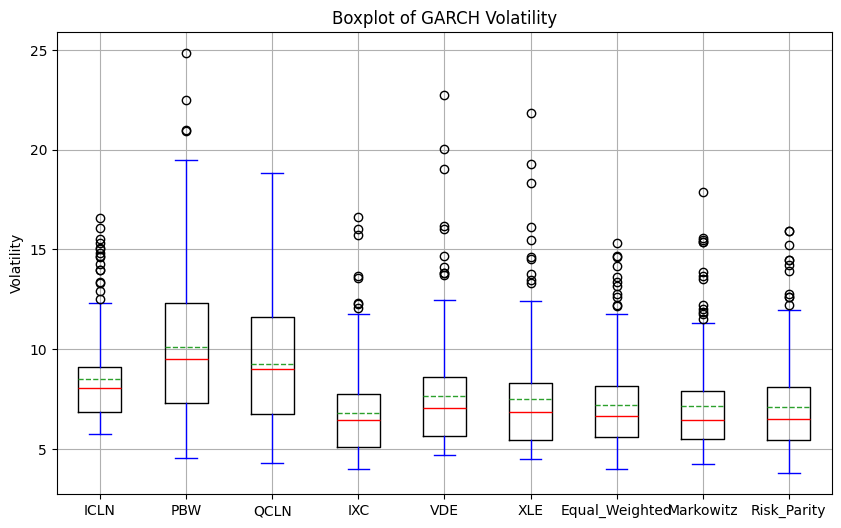

In [44]:
plt.figure(figsize=(10, 6))
plt.boxplot(vol_df.values, labels=vol_df.columns, showfliers=True, showmeans=True, meanline=True, capprops={'color': 'blue'}, whiskerprops={'color': 'blue'}, medianprops={'color': 'red'})
plt.title('Boxplot of GARCH Volatility')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

### Step 5: Risk Metrics

Calculate VaR, CVaR, and Maximum Drawdown.

In [45]:
def risk_metrics(portfolio_returns):
    VaR_95 = portfolio_returns.quantile(0.05)
    CVaR_95 = portfolio_returns[portfolio_returns <= VaR_95].mean()
    drawdown = (portfolio_returns.cummax() - portfolio_returns).max()
    return VaR_95, CVaR_95, drawdown

for col in tickers_and_port:
    VaR, CVaR, MDD = risk_metrics(returns_pivot[col])
    print(f"{col}: VaR={VaR:.4f}, CVaR={CVaR:.4f}, Max Drawdown={MDD:.4f}")


ICLN: VaR=-0.1289, CVaR=-0.2211, Max Drawdown=0.5015
PBW: VaR=-0.1670, CVaR=-0.2283, Max Drawdown=0.6689
QCLN: VaR=-0.1596, CVaR=-0.2114, Max Drawdown=0.5504
IXC: VaR=-0.1024, CVaR=-0.1517, Max Drawdown=0.4729
VDE: VaR=-0.1213, CVaR=-0.1722, Max Drawdown=0.5483
XLE: VaR=-0.1158, CVaR=-0.1702, Max Drawdown=0.5370
Equal_Weighted: VaR=-0.1079, CVaR=-0.1722, Max Drawdown=0.4322
Markowitz: VaR=-0.1137, CVaR=-0.1635, Max Drawdown=0.4642
Risk_Parity: VaR=-0.1058, CVaR=-0.1695, Max Drawdown=0.4384


### Step 6: Hedging and Risk Mitigation Strategies

In [46]:
def apply_stop_loss(portfolio_returns, threshold=-0.05):
    stopped_returns = portfolio_returns.copy()
    stopped_returns[portfolio_returns < threshold] = threshold
    return stopped_returns

returns_pivot['Markowitz_StopLoss'] = apply_stop_loss(returns_pivot['Markowitz'])

In [47]:

VaR_stoploss, CVaR_stoploss, MDD_stoploss = risk_metrics(returns_pivot["Markowitz_StopLoss"])
print(f"Markowitz_StopLoss: VaR={VaR_stoploss:.4f}, CVaR={CVaR_stoploss:.4f}, Max Drawdown={MDD_stoploss:.4f}")

Markowitz_StopLoss: VaR=-0.0500, CVaR=-0.0500, Max Drawdown=0.3522


### Step 7: Backtesting & Benchmarking
Backtest performance against benchmarks.

In [53]:
# S&P 500 Benchmark from WRDS

sp500_query = """
SELECT date, vwretd FROM crsp.msi
WHERE date BETWEEN '2008-07-01' AND '2024-12-31'
"""
sp500 = db.raw_sql(sp500_query, date_cols=['date']).set_index('date')
sp500.index = returns_pivot.index

# save sp500 in csv file in data folder
# sp500.to_csv('data/sp500.csv')


# alternatively, run this
# retrieve sp500 from csv file in data folder
# sp500 = pd.read_csv('data/sp500.csv')
# sp500.index = returns_pivot.index



In [55]:
# Combine with portfolios
returns_pivot = returns_pivot.join(sp500, how='inner')
returns_pivot.rename(columns={'vwretd': 'SP500'}, inplace=True)

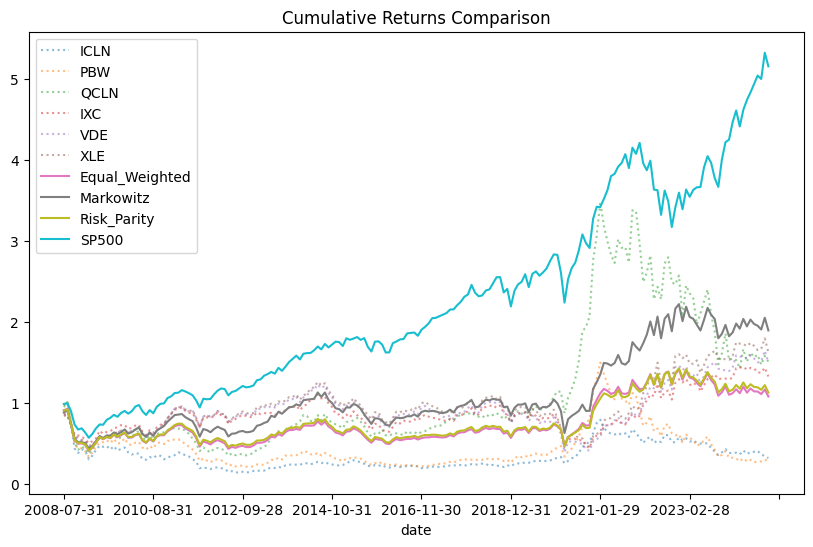

In [84]:
# Combine with portfolios and cumulative returns comparison in the same plot
fig, ax = plt.subplots(figsize=(10,6))
(1 + returns_pivot[tickers]).cumprod().plot(ax=ax, linestyle = ":", alpha = 0.5)
(1 + returns_pivot[['Equal_Weighted', 'Markowitz', 'Risk_Parity', 'SP500']]).cumprod().plot(ax=ax, linestyle = "-")
ax.set_title("Cumulative Returns Comparison")
ax.legend(tickers + ['Equal_Weighted', 'Markowitz', 'Risk_Parity', 'SP500'])
plt.show()

### Step 8: Walk farward Validation
Conduct rolling-window optimization.

In [233]:
window_size = 60  # 5 years
step_size = 12  # 1 year
performance = []

for start in range(0, len(returns_pivot) - window_size, step_size):
    train = returns_pivot.iloc[start:start+window_size][tickers]
    test = returns_pivot.iloc[start+window_size:start+window_size+step_size][tickers]
    weights = markowitz_opt(train)
    test_perf = test.dot(weights).mean() * 12  # annualized
    performance.append(test_perf)

print("Walk-forward Annualized Performance:", performance)


Walk-forward Annualized Performance: [0.2733340000000001, -0.24684899999999999, -0.03754099999999996, 0.054939744749074426, 0.08682799999999999, 0.12016299999999999, 0.36634146846513416, 0.96288, -0.2559954035815093, 0.06011686174894443, -0.2610190771914261, -0.0361379271654574]
